# 5TERA_chi2.ipynb
### Marcus Viscardi,    May 04, 2022

Moving things over from 5TERA_analyses to limit overlapping code

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', None)

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

from nanoporePipelineCommon import *

print("imports done")

imports done


In [2]:
reads_df_genes_raw, compressed_df_genes_raw = load_and_merge_lib_parquets(["xrn-1-5tera", "xrn-1-5tera-smg-6"], drop_sub_n=1, add_tail_groupings=False, drop_failed_polya=False, group_by_t5=True)
print("done.")

Loading readAssignments file from: /data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.allChrs.parquet... Done.
Looking for files for libraries: ['xrn-1-5tera', 'xrn-1-5tera-smg-6']
Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Loading parquet for xrn-1-5tera lib... Done.
'original_chr_pos' column already found in dataframe, skipping adjustment for 5'ends!
Loading parquet for xrn-1-5tera-smg-6 lib... Done.
'original_chr_pos' column already found in dataframe, skipping adjustment for 5'ends!
Finished assignment merge!. . .
Read counts post gene assignment:  937835
Read counts post unassigned drop:  636409
Creating groupby dataframe merged on: ['lib', 'chr_id', 'gene_i

Counting reads per gene: 100%|██████████| 31278/31278 [00:00<00:00, 65533.35it/s]


Gene counts pre sub-1 gene_hits drop:  31278
Gene counts post sub-1 gene_hits drop:  31278
done.


In [4]:
compressed_df_genes_short = compressed_df_genes_raw.copy()[["lib", "chr_id", "gene_id", "gene_name", "t5", "gene_hits", "gene_rpm"]]
compressed_df_genes_short.query("gene_name == 'rpl-12'")

,lib,chr_id,gene_id,gene_name,t5,gene_hits,gene_rpm
10219,xrn-1-5tera,IV,WBGene00004424,rpl-12,-,1759,3710.195550
10220,xrn-1-5tera,IV,WBGene00004424,rpl-12,+,49,103.353941
25572,xrn-1-5tera-smg-6,IV,WBGene00004424,rpl-12,-,513,3160.618569
25573,xrn-1-5tera-smg-6,IV,WBGene00004424,rpl-12,+,6,36.966299


In [5]:
conversion_dict = {"xrn-1-5tera": "n2",
                   "xrn-1-5tera-smg-6": "s6"}
ans = [y for x, y in compressed_df_genes_short.groupby(['lib', 't5'], as_index=False)]
df_dict = {}
for i, df in enumerate(ans):
    lib = df.lib.unique()[0]
    t5 = df.t5.unique()[0]
    df = df[["chr_id", "gene_id", "gene_name", "gene_hits", "gene_rpm"]]
    df = df.rename(columns={col: f'{col}_{conversion_dict[lib]}_t5{t5}' for col in df.columns if col not in ["chr_id", "gene_id", "gene_name"]})
    df_dict[(conversion_dict[lib], t5)] = df.set_index(["chr_id", "gene_id", "gene_name"])
    print((conversion_dict[lib], t5))
    print(df_dict[(conversion_dict[lib], t5)].query("gene_name == 'rpl-12'"))

super_df = pd.concat(df_dict.values(), axis=1, join='outer').fillna(0)
super_df

('n2', '+')
                                 gene_hits_n2_t5+  gene_rpm_n2_t5+
chr_id gene_id        gene_name                                   
IV     WBGene00004424 rpl-12                   49       103.353941
('n2', '-')
                                 gene_hits_n2_t5-  gene_rpm_n2_t5-
chr_id gene_id        gene_name                                   
IV     WBGene00004424 rpl-12                 1759       3710.19555
('s6', '+')
                                 gene_hits_s6_t5+  gene_rpm_s6_t5+
chr_id gene_id        gene_name                                   
IV     WBGene00004424 rpl-12                    6        36.966299
('s6', '-')
                                 gene_hits_s6_t5-  gene_rpm_s6_t5-
chr_id gene_id        gene_name                                   
IV     WBGene00004424 rpl-12                  513      3160.618569


gene_hits_n2_t5+  gene_rpm_n2_t5+  gene_hits_n2_t5-  gene_rpm_n2_t5-  gene_hits_s6_t5+  gene_rpm_s6_t5+  gene_hits_s6_t5-  gene_rpm_s6_t5-
chr_id gene_id        gene_name                                                                                                                                            
I      WBGene00000001 aap-1                   2.0         4.218528              18.0        37.966754               1.0          6.16105               1.0         6.161050
       WBGene00000006 aat-5                   1.0         2.109264               2.0         4.218528               0.0          0.00000               1.0         6.161050
       WBGene00000010 aat-9                   0.0         0.000000               7.0        14.764849               0.0          0.00000               1.0         6.161050
       WBGene00000020 abt-2                   0.0         0.000000               4.0         8.437056               0.0          0.00000               5.0        30.805249
       WBGene00000023 abt-5                   1.0         2.109264               3.0         6.327792               0.0          0.00000               0.0         0.000000
...                                           ...              ...               ...              ...               ...              ...               ...              ...
X      WBGene00271701 F10D7.10                1.0         2.109264               0.0         0.000000               0.0          0.00000               1.0         6.161050
       WBGene00284849 C03A3.9                 0.0         0.000000               2.0         4.218528               0.0          0.00000               3.0        18.483150
       WBGene00284855 C04C11.25               0.0         0.000000               1.0         2.109264               0.0          0.00000               0.0         0.000000
       WBGene00303024 H40L08.7                8.0        16.874113               7.0        14.764849               0.0          0.00000               1.0         6.161050
       WBGene00303081 T23F2.13                0.0         0.000000               1.0         2.109264               0.0          0.00000               0.0         0.000000

[13508 rows x 8 columns]

In [7]:
# # This is super hacky way to better handle zero values... by making them non-zero
# read_counts_columns = [col for col in super_df.columns if "hits" in col]
# for col in read_counts_columns:
#     super_df[col] += 0.1

In [8]:
# Below was all test code

# def make_contingency_table(row, as_df=True):
#     array = np.array([[row["gene_hits_n2_t5-"][0], row["gene_hits_s6_t5-"][0]],
#                       [row["gene_hits_n2_t5+"][0], row["gene_hits_s6_t5+"][0]]])
#     if as_df:
#         little_df = pd.DataFrame(array, columns=['n2', 'smg-6'], index=['t5 -', 't5 +'])
#         return little_df
#     else:
#         return array
# 
# make_contingency_table(super_df.query("gene_name == 'aco-1'"))

# from scipy.stats import chi2_contingency, chisquare, fisher_exact
# def test_gene_chi2(gene):
#     example_case = make_contingency_table(super_df.query(f"gene_name == '{gene}'"))
#     print(f"{gene}:")
#     print(example_case)
#     chi2, p, deg_of_free, expected = chi2_contingency(np.array(example_case))
#     print(f"{'chi2':>20} = {chi2:.6f}\n"
#           f"{'p value':>20} = {p:.3g}\n"
#           f"{'degrees of freedom':>20} = {deg_of_free:.6f}\n"
#           #f"{'expected:':>20}\n{expected}"
#           )
# 
# # Example case:
# example_genes = ['acdh-1', 'xrn-1', 'nduo-3', 'rpl-22', 'ets-4', 'ubl-1', 'rpl-12'
#                                                                           ]
# for example_gene in example_genes:
#     test_gene_chi2(example_gene)

In [6]:
from scipy.stats import chi2_contingency, chisquare, fisher_exact, boschloo_exact, barnard_exact
def row_chi2(row):
    array = np.array([[row["gene_hits_n2_t5-"], row["gene_hits_s6_t5-"]],
                      [row["gene_hits_n2_t5+"], row["gene_hits_s6_t5+"]]])
    try:
        chi2, p, deg_of_free, expected = chi2_contingency(array)
        return chi2, p
    except ValueError:
        return None, None


def row_fishers_exact(row, hits_or_rpm='hits', alternative='two-sided'):
    array = np.array([[row[f"gene_{hits_or_rpm}_n2_t5-"], row[f"gene_{hits_or_rpm}_s6_t5-"]],
                      [row[f"gene_{hits_or_rpm}_n2_t5+"], row[f"gene_{hits_or_rpm}_s6_t5+"]]])
    if alternative not in ['two-sided', 'greater', 'less']:
        raise KeyError(f"Please use 'two-sided', 'greater', or 'less' for the alternative hypothesis input for fisher's exact test!!")
    odds_ratio, p_value = fisher_exact(array, alternative=alternative)
    return odds_ratio, p_value

def row_boschloo_exact(row, hits_or_rpm='hits', alternative='two-sided', sampling_points=32):
    array = np.array([[row[f"gene_{hits_or_rpm}_n2_t5-"], row[f"gene_{hits_or_rpm}_s6_t5-"]],
                      [row[f"gene_{hits_or_rpm}_n2_t5+"], row[f"gene_{hits_or_rpm}_s6_t5+"]]])
    if alternative not in ['two-sided', 'greater', 'less']:
        raise KeyError(f"Please use 'two-sided', 'greater', or 'less' for the alternative hypothesis input for Boschloo's exact test!!")
    boschloo_result = boschloo_exact(array, alternative=alternative, n=sampling_points)
    return boschloo_result.statistic, boschloo_result.pvalue

def row_barnard_exact(row, hits_or_rpm='hits', alternative='two-sided', sampling_points=32):
    array = np.array([[row[f"gene_{hits_or_rpm}_n2_t5-"], row[f"gene_{hits_or_rpm}_s6_t5-"]],
                      [row[f"gene_{hits_or_rpm}_n2_t5+"], row[f"gene_{hits_or_rpm}_s6_t5+"]]])
    if alternative not in ['two-sided', 'greater', 'less']:
        raise KeyError(f"Please use 'two-sided', 'greater', or 'less' for the alternative hypothesis input for Barnard's exact test!!")
    barnard_result = barnard_exact(array, alternative=alternative, n=sampling_points)
    return barnard_result.statistic, barnard_result.pvalue


tqdm.pandas(desc="Calculating Chi Squared")
super_df[["chi2_test_result", "chi2_p_value"]] = super_df.progress_apply(lambda row: row_chi2(row), axis=1, result_type="expand")

tqdm.pandas(desc="Calculating Fisher's exact")
super_df[["fishers_test_result", "fishers_p_value"]] = super_df.progress_apply(lambda row: row_fishers_exact(row, hits_or_rpm='hits', alternative='less'), axis=1, result_type="expand")

# tqdm.pandas(desc="Calculating Barnard's exact")
# super_df[["barnard_test_result", "barnard_p_value"]] = super_df.progress_apply(lambda row: row_barnard_exact(row, hits_or_rpm='hits', alternative='less', sampling_points=2), axis=1, result_type="expand")

print('done.')

Calculating Barnard's exact: 100%|██████████| 13508/13508 [00:15<00:00, 888.85it/s] 

done.


In [7]:
super_df["n2_fraction_adapted"] = super_df["gene_rpm_n2_t5+"] / (super_df["gene_rpm_n2_t5+"] + super_df["gene_rpm_n2_t5-"])
super_df["s6_fraction_adapted"] = super_df["gene_rpm_s6_t5+"] / (super_df["gene_rpm_s6_t5+"] + super_df["gene_rpm_s6_t5-"])

super_df["delta_fraction_adapted"] = super_df["n2_fraction_adapted"] - super_df["s6_fraction_adapted"]

super_df["fraction_adapted_FC"] = np.log2((super_df["n2_fraction_adapted"] / super_df["s6_fraction_adapted"]))
super_df = super_df.replace([np.inf, -np.inf], [6, -6])

super_df["unadapted_FC"] = np.log2((super_df["gene_rpm_n2_t5-"] / super_df["gene_rpm_s6_t5-"]))

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

divide by zero encountered in log2



7499
13508


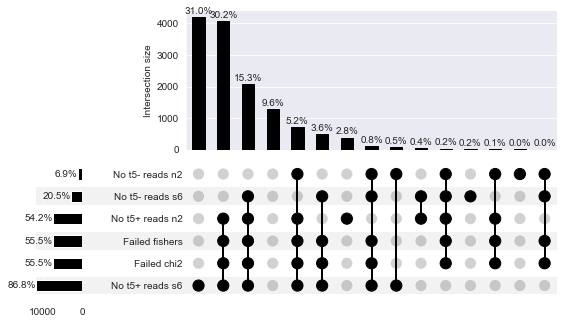

In [8]:
# A lot of genes seem to be failing chi2 b/c of zero values. How many?:
print(super_df[super_df.chi2_p_value.isna()].shape[0])
print(super_df.chi2_p_value.shape[0])
# print(super_df)

def boolDF_to_upsetPlot(input_df: pd.DataFrame):
    import upsetplot
    upset_format_data = upsetplot.from_indicators(lambda lambda_df: lambda_df.select_dtypes(bool), data=input_df)
    fig = plt.figure()
    upset = upsetplot.UpSet(upset_format_data, sort_by='cardinality', sort_categories_by='cardinality', min_subset_size=0, min_degree=0, show_percentages=True)
    upset.plot(fig=fig)
    fig.savefig(f"{get_dt(for_file=True)}_noReads_upset.png")

super_df["No t5+ reads n2"] = super_df["gene_rpm_n2_t5+"] == 0
super_df["No t5- reads n2"] = super_df["gene_rpm_n2_t5-"] == 0
super_df["No t5+ reads s6"] = super_df["gene_rpm_s6_t5+"] == 0
super_df["No t5- reads s6"] = super_df["gene_rpm_s6_t5-"] == 0
super_df['Failed chi2'] = super_df['chi2_p_value'].isna()
super_df['Failed fishers'] = super_df['fishers_test_result'].isna()  # 13 genes?

boolDF_to_upsetPlot(super_df)

In [9]:
# Drop genes that don't have adapted reads in both libraries, or don't have unadapted reads in smg-6
# super_df =\
test_df = super_df[super_df["gene_hits_n2_t5+"] != 0][super_df["gene_hits_s6_t5-"] != 0]
test_df.sort_values(["gene_hits_s6_t5+", "gene_hits_n2_t5+"])
plot_df = test_df

base_sig_cutoff = 0.4
adjusted_sig_cutoff = base_sig_cutoff / plot_df.shape[0]
print(f"P value cutoff of: {adjusted_sig_cutoff:.3g}\nFor both Chi2 and Fishers")

for stat_test in ['chi2', 'barnard', 'boschloo', 'fishers']:
    try:
        plot_df.sort_values(f"{stat_test}_p_value")
        plot_df[f"neg_log10__{stat_test}_p_value"] = - np.log10(plot_df[f"{stat_test}_p_value"])
        plot_df[f"{stat_test}_significant"] = plot_df[f"{stat_test}_p_value"] <= adjusted_sig_cutoff
    except KeyError:
        print(f"Couldn't find columns corrisponding to '{stat_test}'!! Be sure spelling is correct!")

plot_df = plot_df.reset_index()
plot_df['is_MtDNA'] = plot_df['chr_id'] == 'MtDNA'

# Make a col of total read counts
read_counts_columns = [col for col in plot_df.columns if "hits" in col]
plot_df['total_gene_hits'] = plot_df[read_counts_columns].sum(axis=1)
plot_df['log10_total_gene_hits'] = np.log10(plot_df['total_gene_hits'])
read_counts_columns = [col for col in plot_df.columns if "hits" in col]
# print(plot_df[read_counts_columns])

# I want to color by genes from this pub:
# Some NMD targets from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5765348/
list_from_Muir_et_al_2018 = [
    # These are actually from Johns et al. 2007
    "rsp-2", "rsp-6", "rpl-12",
    # his one too but it's actually rpl-1 in worms? rpl-10A is human
    "rpl-10a", "rpl-1",
    # Okay, actually things from Muir et al. 2018 now (I think):
    "Y39B6A.21", "Y51A2D.13", "ZK970.7",
    "B0495.8", "F45D11.1", "F53B2.8",
    "fib-1", "fbxa-33", "linc-9",
    "nhr-109", "pho-11", "pqn-70",
    "tdp-1", "R08E5.3",
    # And a repeat from my hits:
   "rpl-7A", 
   ]

plot_df['Muir_etal_2018_target'] = plot_df['gene_name'].isin(list_from_Muir_et_al_2018)

P value cutoff of: 7.2e-05
For both Chi2 and Fishers
Couldn't find columns corrisponding to 'boschloo'!! Be sure spelling is correct!


/tmp/ipykernel_358472/3423177695.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [12]:
test = 'fishers'  # 'barnard' or 'fishers' or 'chi2'

plot_df = plot_df.query("is_MtDNA == False")
plot_df = plot_df[~plot_df.gene_name.isin(["F23A7.8", "xrn-1", "F23A7.4"])]

fig = px.scatter(plot_df,
                 x="fraction_adapted_FC",
                 y=f"neg_log10__{test}_p_value",
                 hover_name="gene_name",
                 hover_data=plot_df.columns,
                 # color="log10_total_gene_hits",
                 color=f"{test}_significant",
                 # color="unadapted_FC",
                 symbol="is_MtDNA",
                 symbol_sequence=[0, 3],
                 template="plotly_white",
                 render_mode="svg")
fig.update_traces(marker={# 'color': 'black',
                          'opacity': 0.8,
                          'size': 8})
fig.add_hline(-np.log10(adjusted_sig_cutoff), line={'color':'darkred'})
fig.add_annotation(dict(x=0, y=-np.log10(adjusted_sig_cutoff), showarrow=False,
                        text=f"P value cutoff:<br>{adjusted_sig_cutoff:0.3g}",
                        textangle=0, xref="paper", yref="y", align='left'))
fig.update_layout(
                  # height=600, width=600,
                  showlegend=False)
# fig.add_vline(-np.log10(adjusted_sig_cutoff), line={'color':'darkred'})
fig.write_image(f"./{get_dt(for_file=True)}_{test}_significance.svg")
fig.write_html(f"./{get_dt(for_file=True)}_{test}_significance.html")
fig.show()

In [24]:
fig = px.scatter(plot_df,
                 # x="gene_hits_s6_t5-",
                 # x="delta_fraction_adapted",
                 # y="neg_log10__fishers_p_value",
                 x="neg_log10__fishers_p_value",
                 y="neg_log10__barnard_p_value",
                 hover_name="gene_name",
                 hover_data=plot_df.columns,
                 # color='Muir_etal_2018_target',
                 symbol="is_MtDNA",
                 symbol_sequence=[0, 3],
                 template="plotly_white",
                 log_x=True,
                 log_y=True,
                 render_mode="webgl")
fig.update_traces(marker={# 'color': 'black',
                          'opacity': 0.8,
                          'size': 8})
# fig.update_xaxes(range=[np.log10(0.01), np.log10(1.01)])
# fig.add_hline(-np.log10(adjusted_sig_cutoff), line={'color':'darkred'})
fig

In [115]:
plot_df[plot_df['fishers_significant']][['chr_id', 'gene_name', 'gene_id',
                                         'gene_hits_n2_t5+', 'gene_hits_n2_t5-',
                                         'gene_hits_s6_t5+', 'gene_hits_s6_t5-',
                                         'n2_fraction_adapted',
                                         's6_fraction_adapted',
                                         'fishers_p_value',
                                         'fishers_significant',
                                           ]].sort_values("fishers_p_value")

,chr_id,gene_name,gene_id,gene_hits_n2_t5+,gene_hits_n2_t5-,gene_hits_s6_t5+,gene_hits_s6_t5-,n2_fraction_adapted,s6_fraction_adapted,fishers_p_value,fishers_significant
5929,X,F23A7.8,WBGene00044638,226.0,1819.0,92.0,4474.0,0.110513,0.020149,1.798052e-51,True
4248,MtDNA,ctc-1,WBGene00010964,993.0,3201.0,364.0,2679.0,0.236767,0.119619,9.567619e-38,True
4249,MtDNA,ctc-2,WBGene00010965,569.0,1807.0,218.0,1763.0,0.239478,0.110045,2.341611e-29,True
1667,II,xrn-1,WBGene00012730,276.0,7772.0,162.0,13307.0,0.034294,0.012028,8.054807e-28,True
4240,MtDNA,ctb-1,WBGene00000829,420.0,1154.0,108.0,946.0,0.266836,0.102467,1.677713e-26,True
4244,MtDNA,atp-6,WBGene00010960,243.0,1851.0,88.0,2357.0,0.116046,0.035992,1.713955e-25,True
4687,V,F19B2.5,WBGene00008944,82.0,165.0,3.0,250.0,0.331984,0.011858,5.927090e-25,True
5604,X,F23A7.4,WBGene00009069,185.0,1355.0,90.0,2419.0,0.120130,0.035871,3.565870e-24,True
3377,IV,rpl-7A,WBGene00004419,230.0,1340.0,2.0,339.0,0.146497,0.005865,1.405409e-18,True
4245,MtDNA,nduo-2,WBGene00010961,201.0,444.0,55.0,417.0,0.311628,0.116525,3.592811e-15,True


In [46]:
nmd_targets = plot_df[plot_df["fishers_significant"]][['chr_id', 'gene_name', 'gene_id', 'fishers_p_value']].query("chr_id != 'MtDNA'").sort_values('fishers_p_value')
nmd_targets_list = nmd_targets.gene_name.to_list()

# Some NMD targets from: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5765348/
list_from_Muir_et_al_2018 = [
    # These are actually from Johns et al. 2007
    "rsp-2", "rsp-6", "rpl-12",
    # his one too but it's actually rpl-1 in worms? rpl-10A is human
    "rpl-10a", "rpl-1",
    # Okay, actually things from Muir et al. 2018 now (I think):
    "Y39B6A.21", "Y51A2D.13", "ZK970.7",
    "B0495.8", "F45D11.1", "F53B2.8",
    "fib-1", "fbxa-33", "linc-9",
    "nhr-109", "pho-11", "pqn-70",
    "tdp-1", "R08E5.3",
    # And a repeat from my hits:
   "rpl-7A",
   ]

for gene in list_from_Muir_et_al_2018:
    nmd_targets_list.append(gene)


# Some genes that I ID'ed in earlier stages of this process, that might be of interest!
my_genes_of_interest = ["vig-1", "mak-1",  # these appear to have 3' UTR EJC isoforms?
                        "E02C12.8", "K11H12.3", "F14D7.6",  # This looked interesting
                        "D1086.11", "R06C1.4",  # Both have 3' EJCs and look NMD sensitive
                       ]
for gene in my_genes_of_interest:
    nmd_targets_list.append(gene)
with open(f"/home/marcus/Documents/{get_dt(for_file=True)}_myTargets", 'w') as out_file:
    for gene_name in nmd_targets_list:
        hits_or_rpm = 'rpm'
        if gene_name in ["vig-1", "rsp-2", "Y39B6A.21"]:
            print("\n", "#" * 15)
        try:
            row = plot_df.query(f'gene_name == "{gene_name}"').reset_index()
            out_file.write(f"{row['gene_id'][0]}\t{row['gene_name'][0]}\n")
            array = np.array([[row[f"gene_{hits_or_rpm}_n2_t5-"][0],
                           row[f"gene_{hits_or_rpm}_s6_t5-"][0]],
                          [row[f"gene_{hits_or_rpm}_n2_t5+"][0],
                           row[f"gene_{hits_or_rpm}_s6_t5+"][0]]])
            little_df = pd.DataFrame(array, columns=['n2', 'smg-6'], index=['t5 -', 't5 +'])
            print(f"\n{gene_name} ({row['gene_id'][0]}) Chr: {row['chr_id'][0]}")
            print(f"  Fisher's p value: {row['fishers_p_value'][0]:0.3g}")

            column_width = 15
            print(f"            |{'Wildtype:':^{column_width}}|{'smg-6 KO':^{column_width}}|")
            print(f"    Adapted:|{array[0][0]:>{column_width-4}.3f} rpm|{array[0][1]:>{column_width-4}.3f} rpm|")
            print(f"  Unadapted:|{array[1][0]:>{column_width-4}.3f} rpm|{array[1][1]:>{column_width-4}.3f} rpm|")
        except KeyError:
            print(f"\nFailed to find entry for {gene_name}")
    print(nmd_targets_list)


F23A7.8 (WBGene00044638) Chr: X
  Fisher's p value: 1.78e-51
            |   Wildtype:   |   smg-6 KO    |
    Adapted:|   3836.751 rpm|  27564.537 rpm|
  Unadapted:|    476.694 rpm|    566.817 rpm|

xrn-1 (WBGene00012730) Chr: II
  Fisher's p value: 5.3e-28
            |   Wildtype:   |   smg-6 KO    |
    Adapted:|  16393.201 rpm|  81985.090 rpm|
  Unadapted:|    582.157 rpm|    998.090 rpm|

F19B2.5 (WBGene00008944) Chr: V
  Fisher's p value: 4.74e-25
            |   Wildtype:   |   smg-6 KO    |
    Adapted:|    348.029 rpm|   1540.262 rpm|
  Unadapted:|    172.960 rpm|     18.483 rpm|

F23A7.4 (WBGene00009069) Chr: X
  Fisher's p value: 2.57e-24
            |   Wildtype:   |   smg-6 KO    |
    Adapted:|   2858.053 rpm|  14903.580 rpm|
  Unadapted:|    390.214 rpm|    554.494 rpm|

rpl-7A (WBGene00004419) Chr: IV
  Fisher's p value: 9.88e-19
            |   Wildtype:   |   smg-6 KO    |
    Adapted:|   2826.414 rpm|   2088.596 rpm|
  Unadapted:|    485.131 rpm|     12.322 rpm|

o

In [162]:
def with_dash_for_click_to_copy(input_df: pd.DataFrame):
    from jupyter_dash import JupyterDash
    import json
    from dash import dcc, html, callback_context, dash_table
    import dash_bootstrap_components as dbc
    from dash.dependencies import Input, Output
    import pyperclip
    from webbrowser import open as open_webpage
    # Example for coping to clipboard:
    # pyperclip.copy('The text to be copied to the clipboard.')
    
    merge_df = input_df.copy()
    
    app = JupyterDash(__name__)

    app.layout = dbc.Container(
        [
            dbc.Row(
                # Top row w/ buttons and slider
                [
                    dbc.Col(
                        [
                            dcc.Dropdown(
                                id='x_col',
                                options=[{'label': i, 'value': i} for i in merge_df.columns],
                                value="fraction_adapted_FC"),
                            dcc.Dropdown(
                                id='y_col',
                                options=[{'label': i, 'value': i} for i in merge_df.columns],
                                value="neg_log10__fishers_p_value"),
                        ],
                        width=8,
                        style={'height': '100%'}
                    ),
                    dbc.Col(
                        [
                            html.Button(
                                'Copy selected GENE_NAME',
                                id='btn-nclicks-2',
                                n_clicks=0),
                            html.Button(
                                'Copy selected WBGENE_ID',
                                id='btn-nclicks-1',
                                n_clicks=0),
                            html.Button(
                                'Open WormBase',
                                id='btn-nclicks-3',
                                n_clicks=0),
                            html.Div(
                                id='container-button-timestamp'
                            ),
                            html.Div(
                                id='selected-data'
                            ),
                            html.Div(
                                id='contingency-table',
                            ),
                        ],
                        width=4,
                        style={'height': '100%'}
                    ),
                ],
                className="h-10",
            ),
            dbc.Row(
                # Row for graph!
                [
                    dcc.Graph(id='primary-scatter',
                              style=
                              {
                                  'width': '120vh',
                                  'height': '80vh',
                              }
                              ),
                ],
                className='h-60',
            ),
        ],
        style={'height': '100%', 'width': '100%'},
    )

    @app.callback(Output('primary-scatter', 'figure'),
                  [Input('x_col', 'value'),
                   Input('y_col', 'value'), ])
    def main_plot(x_col, y_col):
        fig = px.scatter(merge_df,
                         x=x_col,
                         y=y_col,
                         hover_name="gene_name",
                         # hover_data=[merge_df.columns],
                         # color="fishers_significant",
                         symbol="is_MtDNA",
                         symbol_sequence=[0, 3],
                         template="plotly_white",
                         opacity=0.8,
                          custom_data=["gene_id", "gene_name"])
        fig.update_traces(marker={'color': 'black',
                                  'opacity': 0.5,
                                  'size': 8})
        fig.add_hline(-np.log10(adjusted_sig_cutoff), line={'color':'darkred'})
        # fig.add_vline(-np.log10(adjusted_sig_cutoff), line={'color':'darkred'})
        fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0},
                          hovermode='closest', clickmode="event+select",
                          template='plotly_white')
        # fig.update_xaxes(type='log')
        # fig.update_yaxes(type='log')
        return fig

    @app.callback(
        Output('selected-data', 'children'),
        [Input('primary-scatter', 'selectedData')])
    def display_selected_data(selectedData):
        if not selectedData:
            return "No points selected"
        return_data = []
        for point_dict in selectedData['points']:
            gene_id, gene_name = point_dict['customdata'][0:2]
            # print(point_dict['customdata'])
            return_data.append({'Gene Name': gene_name,
                                'Gene ID': gene_id})
        return json.dumps(return_data, indent=2)
    
    @app.callback(
        Output('contingency-table', 'children'),
        [Input('primary-scatter', 'selectedData')])
    def display_selected_table(selectedData):
        if not selectedData:
            return "No points selected"
        return_tables =[]
        for point_dict in selectedData['points']:
            gene_id, gene_name = point_dict['customdata'][0:2]
            
            row = plot_df.query(f'gene_id == "{gene_id}"').reset_index()
            # array = np.array([[row["gene_hits_n2_t5-"][0],
            #                    row["gene_hits_s6_t5-"][0]],
            #                   [row["gene_hits_n2_t5+"][0],
            #                    row["gene_hits_s6_t5+"][0]]])
            array = np.array([[row["gene_rpm_n2_t5-"][0],
                   row["gene_rpm_s6_t5-"][0]],
                  [row["gene_rpm_n2_t5+"][0],
                   row["gene_rpm_s6_t5+"][0]]])
            pd.options.display.float_format = '{:,.2g}'.format
            little_df = pd.DataFrame(array, columns=['n2', 'smg-6'], index=['t5 -', 't5 +']).reset_index()
            little_df_columns = [{"name": i, "id": i} for i in little_df.columns]
            table = dash_table.DataTable(data=little_df.to_dict('records'), 
                                         columns=little_df_columns,
                                         )
            return [table]

    @app.callback(
        Output('container-button-timestamp', 'children'),
        [Input('btn-nclicks-1', 'n_clicks'),
         Input('btn-nclicks-2', 'n_clicks'),
         Input('btn-nclicks-3', 'n_clicks'),
         Input('primary-scatter', 'figure'),
         Input('primary-scatter', 'selectedData')])
    def button_click(gene_id, gene_name, open_worm_base, scatter_fig, selectedData):
        changed_id = [p['prop_id'] for p in callback_context.triggered][0]
        if not selectedData:
            return_data = {'gene_name': [],
                           'gene_id': []}
        else:
            return_data = {'gene_name': [],
                           'gene_id': []}
            for point_dict in selectedData['points']:
                gene_id, gene_name = point_dict['customdata'][0:2]
                return_data["gene_name"].append(gene_name)
                return_data["gene_id"].append(gene_id)
        if 'btn-nclicks-2' in changed_id:
            msg = 'Copy gene_id'
            # print(scatter_fig)
            if len(return_data['gene_name']) == 1:
                pyperclip.copy(return_data['gene_name'][0])
            elif len(return_data['gene_name']) > 1:
                pyperclip.copy(', '.join(return_data['gene_name']))
        elif 'btn-nclicks-1' in changed_id:
            msg = 'Copy gene_name'
            if len(return_data['gene_id']) == 1:
                pyperclip.copy(return_data['gene_id'][0])
            elif len(return_data['gene_id']) > 1:
                pyperclip.copy(', '.join(return_data['gene_id']))
        elif 'btn-nclicks-3' in changed_id:
            msg = 'Open worm base'
            if len(return_data['gene_id']) == 1:
                wbgene_id = return_data['gene_id'][0]
                open_webpage(f"https://wormbase.org/species/c_elegans/gene/{wbgene_id}", new=1)
            elif len(return_data['gene_id']) > 1:
                for i, wbgene_id in enumerate(return_data['gene_id']):
                    if i == 0:
                        open_webpage(f"https://wormbase.org/species/c_elegans/gene/{wbgene_id}", new=1)
                    else:
                        open_webpage(f"https://wormbase.org/species/c_elegans/gene/{wbgene_id}", new=2)
        else:
            msg = '*None of the buttons*'
        return html.Div(f"{msg} was most recently clicked")

    app.run_server(mode='external')

# This doesn't work lol
with_dash_for_click_to_copy(plot_df.reset_index())

Dash app running on http://127.0.0.1:8050/


In [38]:
gene_name = 'ubl-1'
hits_or_rpm = 'hits'

row = plot_df.query(f'gene_name == "{gene_name}"').reset_index()
array = np.array([[row[f"gene_{hits_or_rpm}_n2_t5-"][0],
                   row[f"gene_{hits_or_rpm}_s6_t5-"][0]],
                  [row[f"gene_{hits_or_rpm}_n2_t5+"][0],
                   row[f"gene_{hits_or_rpm}_s6_t5+"][0]]])
little_df = pd.DataFrame(array, columns=['n2', 'smg-6'], index=['t5 -', 't5 +'])
little_df

,n2,smg-6
t5 -,1805.0,549.0
t5 +,84.0,4.0
